In [1]:
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('bmh')

import matplotlib.dates as mdates
import plotly
plotly.offline.init_notebook_mode()

from matplotlib.ticker import ScalarFormatter

from bokeh.io import output_notebook, export_svgs, save, output_file
from bokeh.plotting import figure, show
from bokeh.models import (GeoJSONDataSource,ColumnDataSource,HoverTool,LogColorMapper,ColorBar,LogTicker)
from bokeh.palettes import Oranges9 as palette # https://bokeh.pydata.org/en/latest/docs/reference/palettes.html
output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

Attention: the data used here was manually collected from the posts at https://www.rivm.nl/en/news/current-information-about-novel-coronavirus-covid-19

In [13]:
df=pd.read_csv('data/overall_stats.csv',sep=";")
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y') 
df = df.set_index('date')

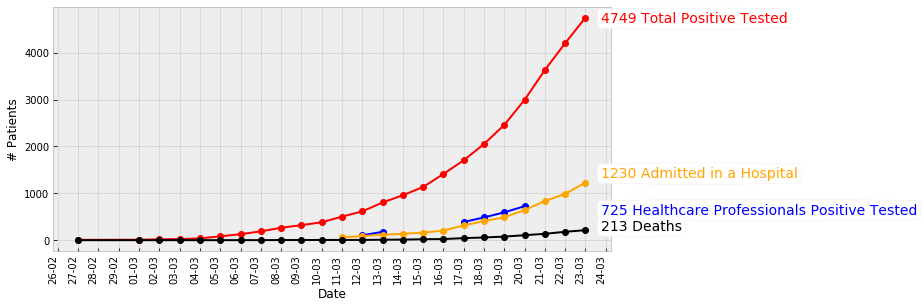

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot2grid((1,1), (0,0))
# ax.set_title("Cummulative Number of Patients Per Day in The Netherlands",fontsize=16)

df['positive_tested'].plot(ax=ax,color='red',style='-o')
df['healthcare'].plot(ax=ax,color='blue',style='-o')
df['admitted_hospital'].plot(ax=ax,color='orange',style='-o')
df['total_fatalities'].plot(ax=ax,color='black',style='-o')

ax.set_xlabel("Date",color='black')
ax.set_ylabel("# Patients",color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', rotation=90, labelsize=10)

# plt.legend(['Positive-tested','Healthcare professionals positive-tested','Admitted in a hospital','Deaths']);


plt.annotate(str(df['positive_tested'].max())+" Total Positive Tested", 
             size=14,
             color='red',
             xy=(1, df['positive_tested'].max()), 
             xytext=(-10, -5), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['healthcare'].max()))+" Healthcare Professionals Positive Tested", 
             size=14,
             color='blue',
             xy=(1, df['healthcare'].max()), 
             xytext=(-10, -8), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['admitted_hospital'].max()))+" Admitted in a Hospital", 
             size=14,
             color='orange',
             xy=(1, df['admitted_hospital'].max()), 
             xytext=(-10, 5), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['total_fatalities'].max()))+" Deaths", 
             size=14,
             color='black',
             xy=(1, df['total_fatalities'].max()), 
             xytext=(-10, 0), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))
             
fig.savefig('figs/overall_cummulative_stats.png', bbox_inches='tight',format='png', dpi=1200, transparent=True)
fig.show()
# plotly.offline.iplot_mpl(fig)

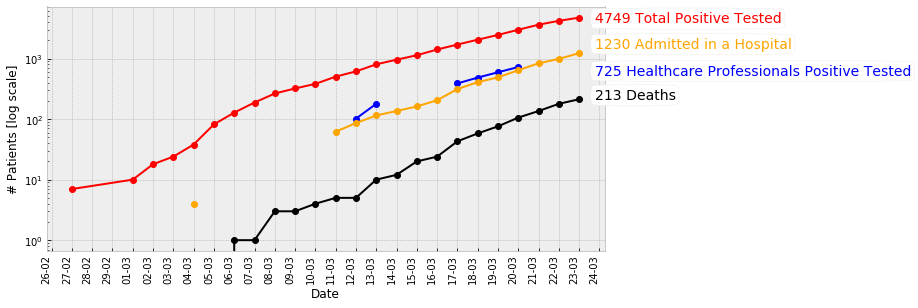

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot2grid((1,1), (0,0))
# ax.set_title("Cummulative Number of Patients Per Day in The Netherlands",fontsize=16)

df['positive_tested'].plot(ax=ax,color='red',style='-o')
df['healthcare'].plot(ax=ax,color='blue',style='-o')
df['admitted_hospital'].plot(ax=ax,color='orange',style='-o')
df['total_fatalities'].plot(ax=ax,color='black',style='-o')

ax.set_xlabel("Date",color='black')
ax.set_ylabel("# Patients [log scale]",color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', rotation=90, labelsize=10)

ax.set_yscale('log')
# plt.legend(['Positive-tested','Healthcare professionals positive-tested','Admitted in a hospital','Deaths']);


plt.annotate(str(df['positive_tested'].max())+" Total Positive Tested", 
             size=14,
             color='red',
             xy=(1, df['positive_tested'].max()), 
             xytext=(-10, -5), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['healthcare'].max()))+" Healthcare Professionals Positive Tested", 
             size=14,
             color='blue',
             xy=(1, df['healthcare'].max()), 
             xytext=(-10, -8), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['admitted_hospital'].max()))+" Admitted in a Hospital", 
             size=14,
             color='orange',
             xy=(1, df['admitted_hospital'].max()), 
             xytext=(-10, 5), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))

plt.annotate(str(int(df['total_fatalities'].max()))+" Deaths", 
             size=14,
             color='black',
             xy=(1, df['total_fatalities'].max()), 
             xytext=(-10, 0), 
             xycoords=('axes fraction', 'data'), 
             textcoords='offset points',
             bbox=dict(boxstyle="round4", fc="w"))
             
fig.savefig('figs/overall_cummulative_stats_logscale.png', bbox_inches='tight',format='png', dpi=1200, transparent=True)
fig.show()
# plotly.offline.iplot_mpl(fig)

## Geographical heatmap with actual values per Gemeente

In [5]:
import json
from collections import OrderedDict

with open(r'data/dutch_municipalities_and_provinces.geojson', 'r') as f:
    nl_gemeentes = json.loads(f.read(), object_hook=OrderedDict)

Reading the values of the day

In [21]:
df = pd.read_csv('data/covid19-nl-23-03-2020.csv')

Merging the day values with the geo_source:

*There are several Gemeentes with different names in both lists (capital letters, remove parentesis). For example: Dongeradeel =  Ferwerderadiel + Kollumerland en Nieuwkruisland; Now it is called: 'Noardeast-Fryslân'

In [22]:
missing=[]
for gemeente in nl_gemeentes['features']: 
    gemeente_name = re.sub(r"[\(\[].*?[\)\]]", "",gemeente['properties']['municipality']).strip()
    try:
        value = df[df['Gemeente'].str.contains(gemeente_name,case=False)]['Aantal'].values[0]
    except:
        value = -1
        missing.append(gemeente_name)
        
    gemeente['properties']['created_values'] = int(value)

In [23]:
geo_source = GeoJSONDataSource(geojson=json.dumps(nl_gemeentes))

In [25]:
palette.reverse() #for heatmap 
color_mapper = LogColorMapper(palette=palette,low=1,high=df['Aantal'].max())

# TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
TOOLS = "hover"

p = figure(
#     title="COVID-19 cases in Dutch provinces", 
    tools=TOOLS,
     x_axis_location=None, y_axis_location=None
)

p.patches('xs', 'ys', 
          source=geo_source,
          fill_color={'field': 'created_values', 
                      'transform': color_mapper},
          fill_alpha=1, 
          line_color="black", 
          line_width=0.5)


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@municipality"),
    ("Created Values", "@created_values"),
]

color_bar = ColorBar(color_mapper=color_mapper, 
                     ticker=LogTicker(),
                     label_standoff=5, 
                     border_line_color='#f2f2f2',
                     background_fill_color = '#f2f2f2',
                     location=(0,0))
p.add_layout(color_bar, 'right')


p.grid.grid_line_color = '#f2f2f2'
p.background_fill_color = '#f2f2f2'
p.border_fill_color = '#f2f2f2'
p.output_backend = "svg"


show(p)
output_file("_includes/geo_heatmap_actual_numbers.html")
save(p)

'/Users/santannajj/Desktop/crawling_stats_from_rivm_covid19/_includes/geo_heatmap_actual_numbers.html'

Top Gemeentes with more cases:

In [26]:
top_gemeente = df[['Aantal','Gemeente']].sort_values(by='Aantal', ascending=False).reset_index(drop=True)[:10]

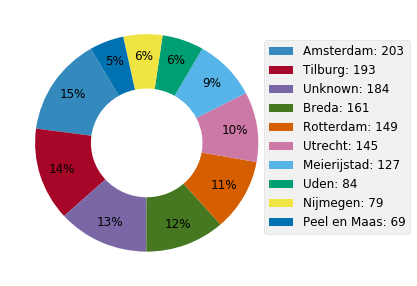

In [28]:
fig = plt.figure(figsize=(5, 5))  
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.0f' % pct)+"%" if pct > 2 else ''

top_gemeente.plot(ax=ax1,y='Aantal',kind='pie', labels=None, autopct=my_autopct,startangle=120,pctdistance=0.8, labeldistance=1.05,fontsize=12,wedgeprops=dict(width=0.5))
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(top_gemeente['Gemeente'], top_gemeente['Aantal'])]
legend_show_top=10
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(0.9, 0.9),
           fontsize=12).set_zorder(0)

fig.show()
# fig.savefig(output_figures+'nameservers_pie.eps', bbox_inches='tight',format='eps', dpi=1200)
# fig.savefig(output_figures+'nameservers_pie.png', bbox_inches='tight',format='eps', dpi=1200, transparent=True)

## Merging stats of Geements in multiple dates (and exporting to html):

In [29]:
import glob
df=pd.DataFrame(columns=['Gemeente'])
for file in sorted(glob.glob("data/covid*")):
    date = '-'.join(file.split('.')[0].split('-')[2:5])
    df_temp = pd.read_csv(file)[['Gemeente','Aantal']]
    df_temp.rename(columns={"Aantal": date},inplace=True)
    df = pd.merge(df,df_temp,on='Gemeente',how='outer')
df.head()

Gemeente  20-03-2020  21-03-2020  22-03-2020  23-03-2020
0           Unknown         112         137         155         184
1     's-Gravenhage          36          44          47          53
2  's-Hertogenbosch          38          45          55          60
3       Aa en Hunze           0           0           1           1
4          Aalsmeer           5           5           7           8

In [30]:
f = open('_includes/tab_history_per_gemeente.html', 'wt', encoding='utf-8')
f.write(df.to_html())

47458